C:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:59:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     11136
           1       0.95      0.96      0.96     32641
           2       0.86      0.50      0.63       223

    accuracy                           0.94     44000
   macro avg       0.90      0.78      0.82     44000
weighted avg       0.94      0.94      0.94     44000



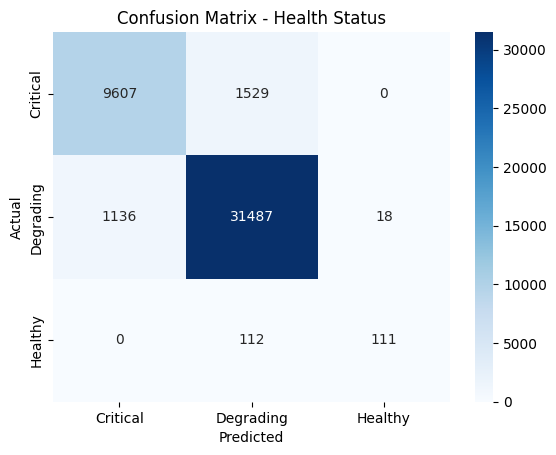

Subset 1 - R²: 0.9795, MSE: 1.80, MAE: 0.81
Subset 2 - R²: 0.9793, MSE: 1.83, MAE: 0.81
Subset 3 - R²: 0.9792, MSE: 1.83, MAE: 0.81
Subset 4 - R²: 0.9794, MSE: 1.78, MAE: 0.80
Subset 5 - R²: 0.9790, MSE: 11.94, MAE: 2.16

Overall Regression Model R²: 0.9504
Overall Regression Model MSE: 12.33
Overall Regression Model MAE: 2.19
✅ Model performs very well.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error
)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

file_path = "oxygen_sensor_final_with_faults.csv"
df = pd.read_csv(file_path)

df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True).str.replace(" ", "_")

def classify_health(performance):
    if performance >= 80:
        return 2  
    elif 50 <= performance < 80:
        return 1  
    else:
        return 0  

df["HealthStatus"] = df["OxygenSensorPerformance"].apply(classify_health)

X_class = df.drop(columns=["OxygenSensorPerformance", "HealthStatus"])
y_class = df["HealthStatus"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_c, y_train_c)

y_pred_class = xgb_model.predict(X_test_c)
print("Classification Report:")
print(classification_report(y_test_c, y_pred_class))

conf_matrix = confusion_matrix(y_test_c, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Critical", "Degrading", "Healthy"],
            yticklabels=["Critical", "Degrading", "Healthy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Health Status")
plt.show()

X_train_c = X_train_c.copy()
X_test_c = X_test_c.copy()
X_train_c["PredictedHealthStatus"] = xgb_model.predict(X_train_c)
X_test_c["PredictedHealthStatus"] = y_pred_class

y_train_reg = df.loc[X_train_c.index, "OxygenSensorPerformance"]
y_test_reg = df.loc[X_test_c.index, "OxygenSensorPerformance"]

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_c, y_train_reg)

num_subsets = 5
df_subsets = np.array_split(df, num_subsets)

for i, subset in enumerate(df_subsets):
    X_subset = subset.drop(columns=["OxygenSensorPerformance", "HealthStatus"])
    X_subset["PredictedHealthStatus"] = xgb_model.predict(X_subset)
    y_subset = subset["OxygenSensorPerformance"]
    y_pred_subset = rf_regressor.predict(X_subset)
    r2_subset = r2_score(y_subset, y_pred_subset)
    mse_subset = mean_squared_error(y_subset, y_pred_subset)
    mae_subset = mean_absolute_error(y_subset, y_pred_subset)
    print(f"Subset {i+1} - R²: {r2_subset:.4f}, MSE: {mse_subset:.2f}, MAE: {mae_subset:.2f}")

y_pred_reg = rf_regressor.predict(X_test_c)
r2 = r2_score(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print(f"\nOverall Regression Model R²: {r2:.4f}")
print(f"Overall Regression Model MSE: {mse:.2f}")
print(f"Overall Regression Model MAE: {mae:.2f}")

if r2 > 0.8:
    print("✅ Model performs very well.")
elif r2 > 0.6:
    print("⚠️ Model is decent, but there’s room for improvement.")
else:
    print("❌ Model performance is poor. Needs tuning or more data.")